#Import libraries

In [2]:
#Libraries needed to run the tool
import time, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import scipy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import plot_confusion_matrix
from scipy import stats as stat_
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import  DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import  DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#Load Data

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#%cd /content/drive/My Drive/Colab Notebooks

In [5]:
gt = pd.read_csv('globalterrorismdb_0718dist.csv', encoding = "ISO-8859-1", low_memory=False)

#Basics

In [6]:
gt.shape

(181691, 135)

In [7]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Columns: 135 entries, eventid to related
dtypes: float64(55), int64(22), object(58)
memory usage: 187.1+ MB


In [8]:
# Just to make sure
gtcopy = gt.copy()
gtcopy1 = gt.copy()

In [9]:
#missing variables #percentage of null values in columns
count = 0
no_null = []
for i in gt.columns:
    data_col = gt[i]
    #print (i, " ",round((data_col.isnull().sum()/len(gt)*100), 4), gt[i].dtype)
    if data_col.isnull().sum()/len(gt)*100 < 5:
        count += 1
        no_null.append(i)

print('columns with < 5 percent  null values: %d' %(count))


columns with < 5 percent  null values: 41


In [10]:
gtcopy5=gtcopy.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','approxdate':'Date','country_txt':'Country','success':'Success_rate','attacktype1_txt':'Attack_type','targtype1_txt':'Target','nkill':'Killed','weaptype1_txt':'Weapon_type','nwound':'Wounded','city':'City','gname':'Attacker'})

In [11]:
gtcopy5=gtcopy5[['Year','Day','Month','Date','Country','City','Success_rate','Attack_type','Target','Killed','Wounded','Weapon_type','Attacker']]
gtcopy5

,Year,Day,Month,Date,Country,City,Success_rate,Attack_type,Target,Killed,Wounded,Weapon_type,Attacker
0,1970,2,7,NaN,Dominican Republic,Santo Domingo,1,Assassination,Private Citizens & Property,1.0,0.0,Unknown,MANO-D
1,1970,0,0,NaN,Mexico,Mexico city,1,Hostage Taking (Kidnapping),Government (Diplomatic),0.0,0.0,Unknown,23rd of September Communist League
2,1970,0,1,NaN,Philippines,Unknown,1,Assassination,Journalists & Media,1.0,0.0,Unknown,Unknown
3,1970,0,1,NaN,Greece,Athens,1,Bombing/Explosion,Government (Diplomatic),NaN,NaN,Explosives,Unknown
4,1970,0,1,NaN,Japan,Fukouka,1,Facility/Infrastructure Attack,Government (Diplomatic),NaN,NaN,Incendiary,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181686,2017,31,12,NaN,Somalia,Ceelka Geelow,1,Armed Assault,Military,1.0,2.0,Firearms,Al-Shabaab
181687,2017,31,12,NaN,Syria,Jableh,1,Bombing/Explosion,Military,2.0,7.0,Explosives,Muslim extremists
181688,2017,31,12,NaN,Philippines,Kubentog,1,Facility/Infrastructure Attack,Private Citizens & Property,0.0,0.0,Incendiary,Bangsamoro Islamic Freedom Movement (BIFM)
181689,2017,31,12,NaN,India,Imphal,0,Bombing/Explosion,Government (General),0.0,0.0,Explosives,Unknown


In [12]:
gtcopy5.isnull().sum()

Year                 0
Day                  0
Month                0
Date            172452
Country              0
City               434
Success_rate         0
Attack_type          0
Target               0
Killed           10313
Wounded          16311
Weapon_type          0
Attacker             0
dtype: int64

In [13]:
gtcopy5.drop(columns="Date", inplace=True)

In [14]:
gtcopy5.isnull().sum()

Year                0
Day                 0
Month               0
Country             0
City              434
Success_rate        0
Attack_type         0
Target              0
Killed          10313
Wounded         16311
Weapon_type         0
Attacker            0
dtype: int64

In [15]:
gtcopy5.dropna(inplace=True)

#Visualizations & EDA

In [16]:
gt['casualities'] = (gt['nkill'] + gt['nwound'])  #add column for number of casualities = killed + wounded
gt['nclass'] = (gt.casualities.apply(lambda x: 0 if x == 0 else 1))  #create binary interpretation for casualities

In [17]:
# Country-wise analysis of Terror Attacks and their destruction

def country_analysis(data , country=None , feature1=None , feature2=None , line_color=None , palette=None , title =None):
    plt.figure(figsize = (25,8))
    #Plot 1
    plt.subplot(1,2,1)
    sns.countplot(y = data.loc[data['country_txt'] == country]['city'] ,\
                  order = data.loc[data.country_txt == country].city.value_counts()[:10].index,\
                  data = data ,\
                  palette = sns.color_palette(palette,10))
    plt.xticks(rotation = 90)
    plt.title("Terror attacks on Top 10 cities of %s" % (country), weight = 'bold' ,fontsize = 18 ,loc = 'center')
    plt.xlabel('Count',fontsize = 20)
    plt.ylabel('City',fontsize = 20)
    
    

    #Plot 3
    plt.subplot(1,2,2)
    data.query('country_txt == @country').groupby(['iyear'])['casualities'].sum().plot(xticks = data.loc[data.country_txt == country].groupby(['iyear'])['casualities'].sum().index, rot=90 , color = line_color)
    plt.title("Total casualities from (1970 - 2017) in %s" % (country), fontdict = {'fontsize' : 18 , 'weight': 'bold' } , loc = 'center')
    plt.ylabel("Casualities" ,fontsize = 20)
    plt.xlabel('Year',fontsize = 20)
    
    plt.subplots_adjust(wspace = 1 ,hspace =0.5 ,top = 0.5 , bottom = 0.1)  # tune the subplot layout
    plt.tight_layout()   #to avoid overlapping of subplots and fit them cleanly in figure
    plt.show()



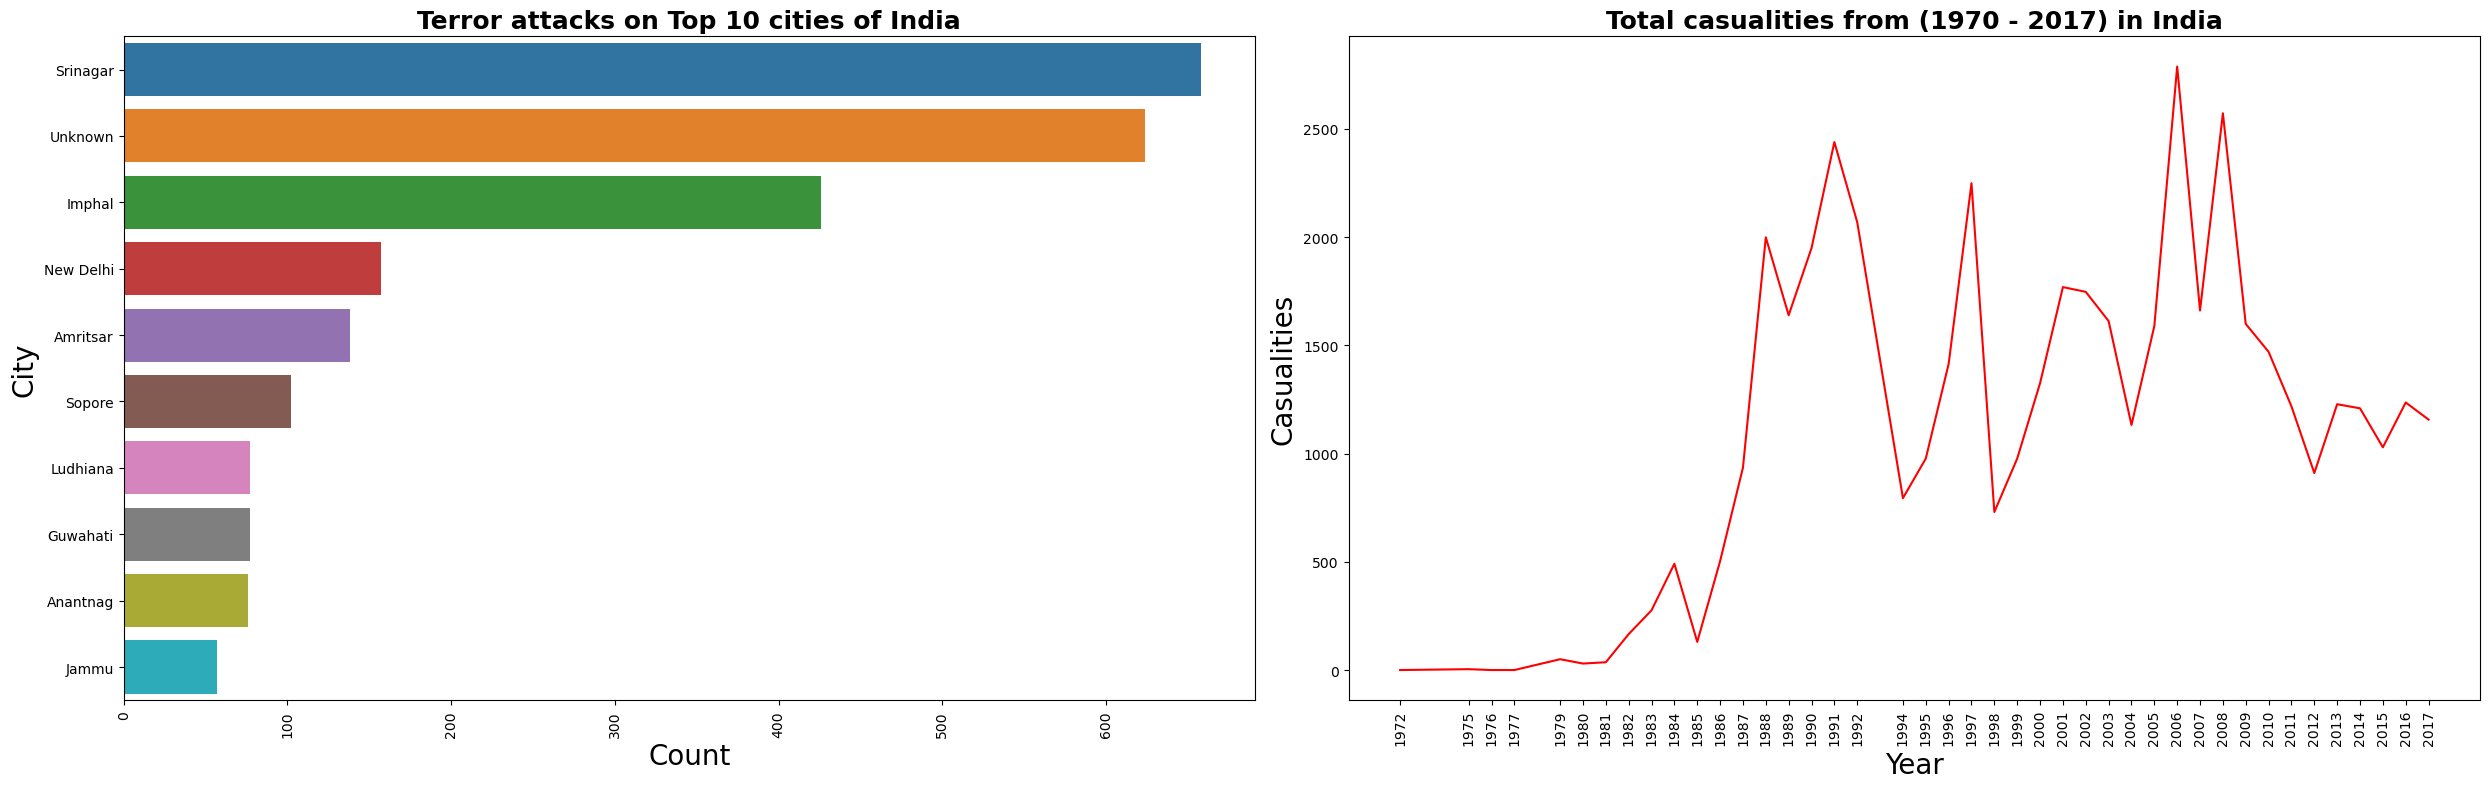

In [18]:
country_analysis(gt, country= 'India', feature1= 'nkill' , feature2= 'attacktype1_txt' , line_color='red' , palette=None , title =None)

Text(0.5, 1.0, 'Successful vs Failed attacks')

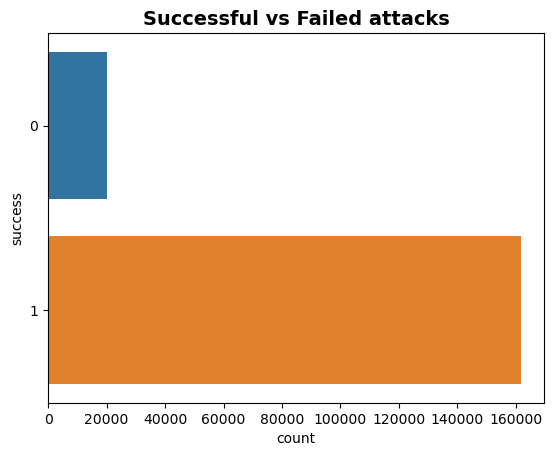

In [19]:
sns.countplot(y ='success', data = gtcopy)
plt.title('Successful vs Failed attacks',fontsize = 14, weight = 'bold', loc = 'center')

Text(0.5, 1.0, 'Number of successful and failed attempts for different kinds of Attacks')

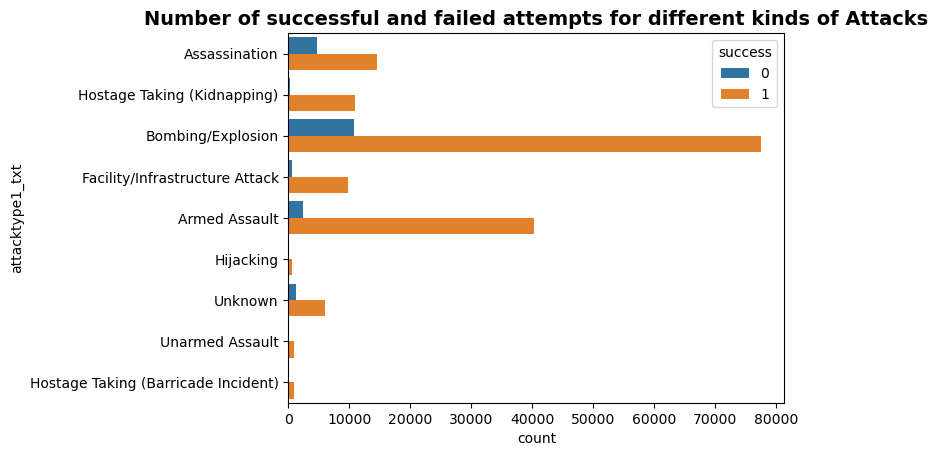

In [20]:
sns.countplot(y ='attacktype1_txt', hue = 'success', data = gtcopy)
plt.title('Number of successful and failed attempts for different kinds of Attacks',fontsize = 14, weight = 'bold', loc = 'center')

Text(0.5, 1.0, 'Number of successful and failed attempts for different weapons')

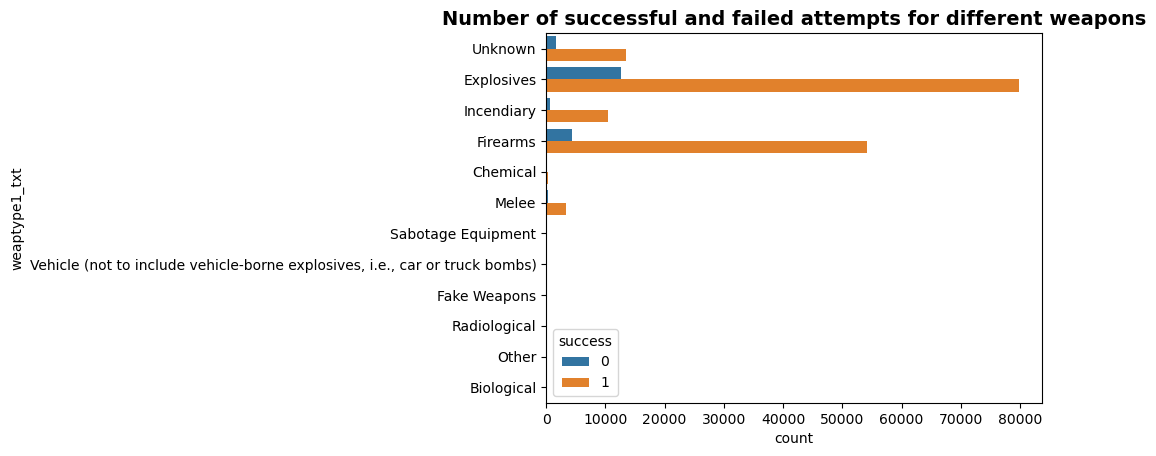

In [21]:
sns.countplot(y ='weaptype1_txt', hue = 'success', data = gtcopy)
plt.title('Number of successful and failed attempts for different weapons',fontsize = 14, weight = 'bold', loc = 'center')

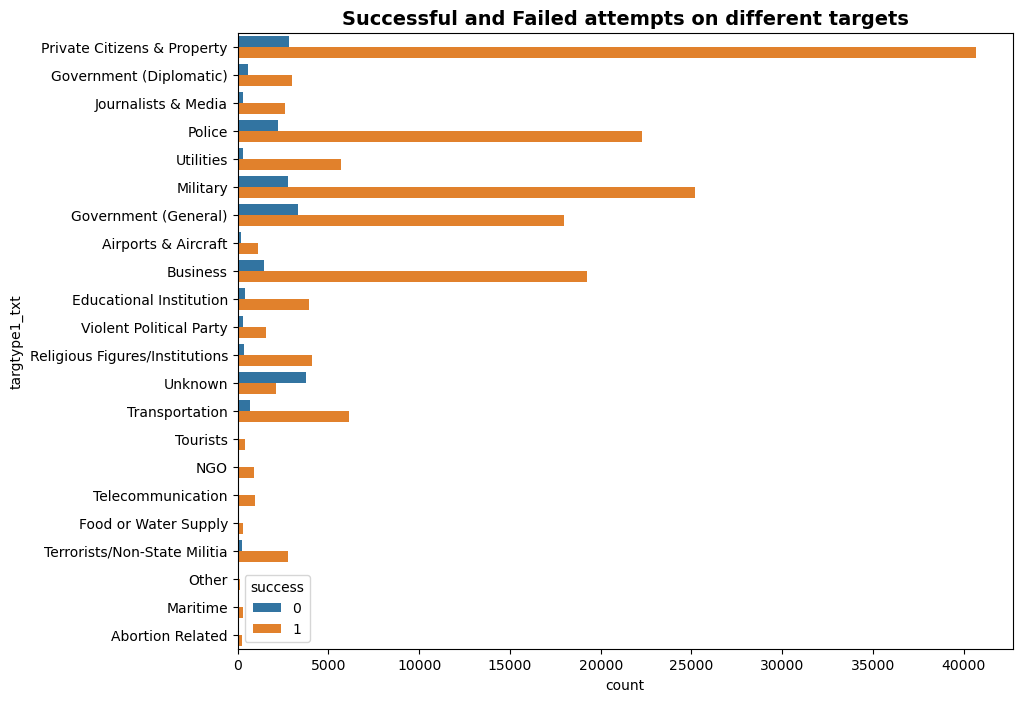

In [22]:
sns.countplot(y ='targtype1_txt', hue = 'success', data = gtcopy)
plt.title("Successful and Failed attempts on different targets",fontsize = 14, weight = 'bold', loc = 'center')
fig=plt.gcf()
fig.set_size_inches(10,8)

Text(0.5, 1.0, 'Successful and Failed attempts when guns are and aren’t used')

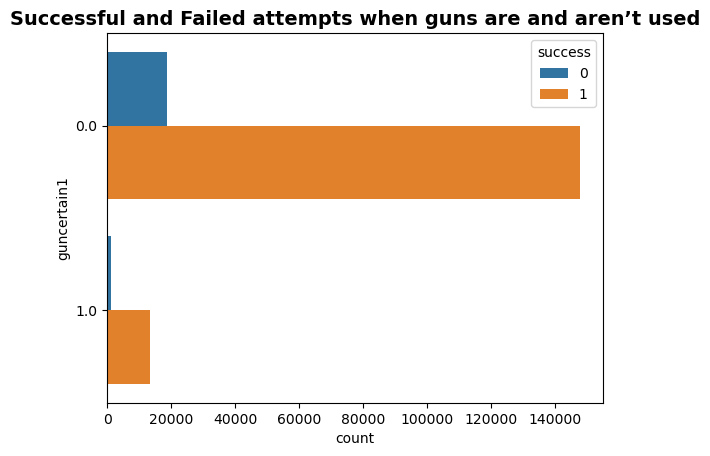

In [23]:
sns.countplot(y ='guncertain1', hue = 'success', data = gtcopy)
plt.title("Successful and Failed attempts when guns are and aren’t used",fontsize = 14, weight = 'bold', loc = 'center')

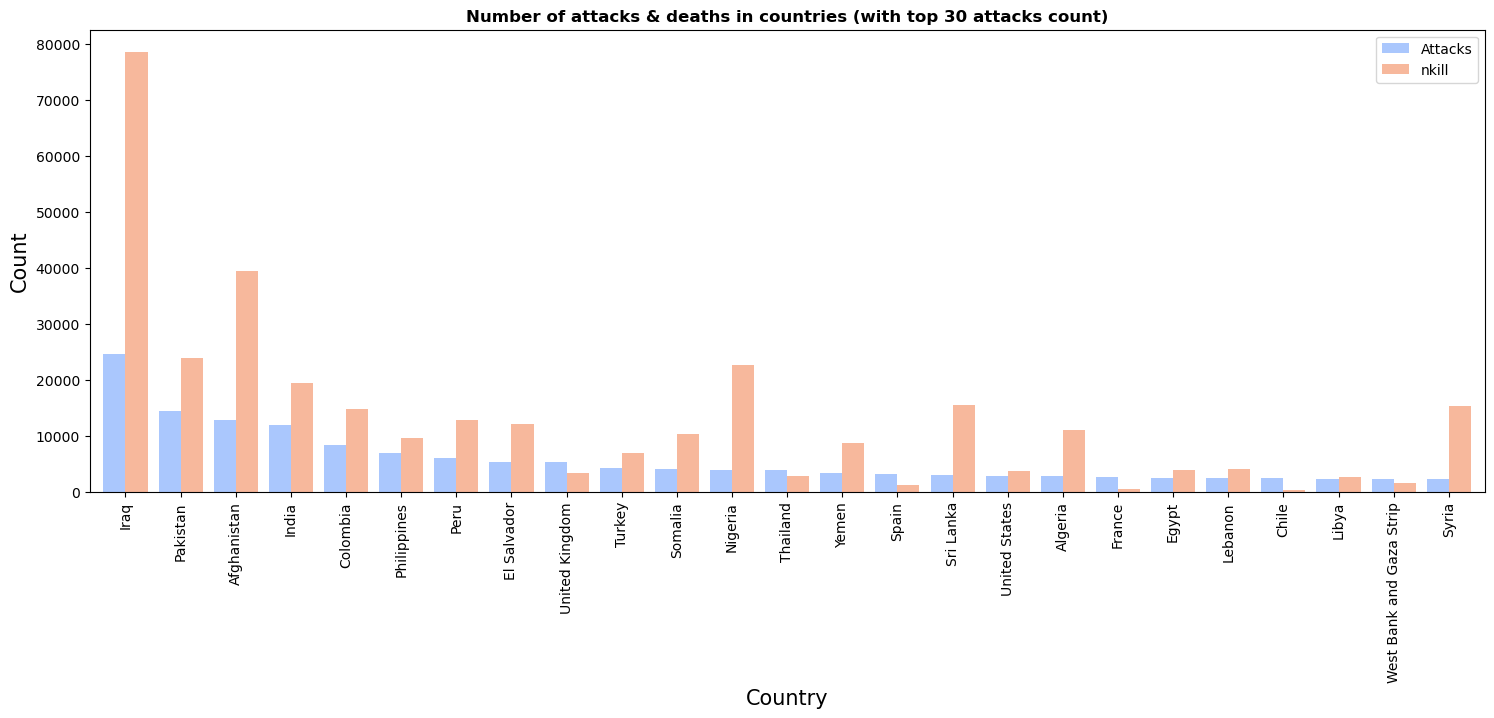

In [24]:
# Comparing No. of Attacks with Killings for each country
attacks = gtcopy.country_txt.value_counts()[: 25].to_frame()
attacks.columns = ['Attacks']
kills = gtcopy.groupby(['country_txt'])['nkill'].sum().sort_values(ascending =False).to_frame()
attacks.merge(kills, how = 'left' , left_index = True, right_index = True ).plot.bar(width = 0.8 , color = sns.color_palette('coolwarm',2))
fig=plt.gcf()
fig.set_size_inches(18,6)
plt.ylabel("Count" ,fontsize = 15)
plt.xlabel("Country",fontsize = 15)
plt.title('Number of attacks & deaths in countries (with top 30 attacks count)', weight = 'bold')
plt.show()

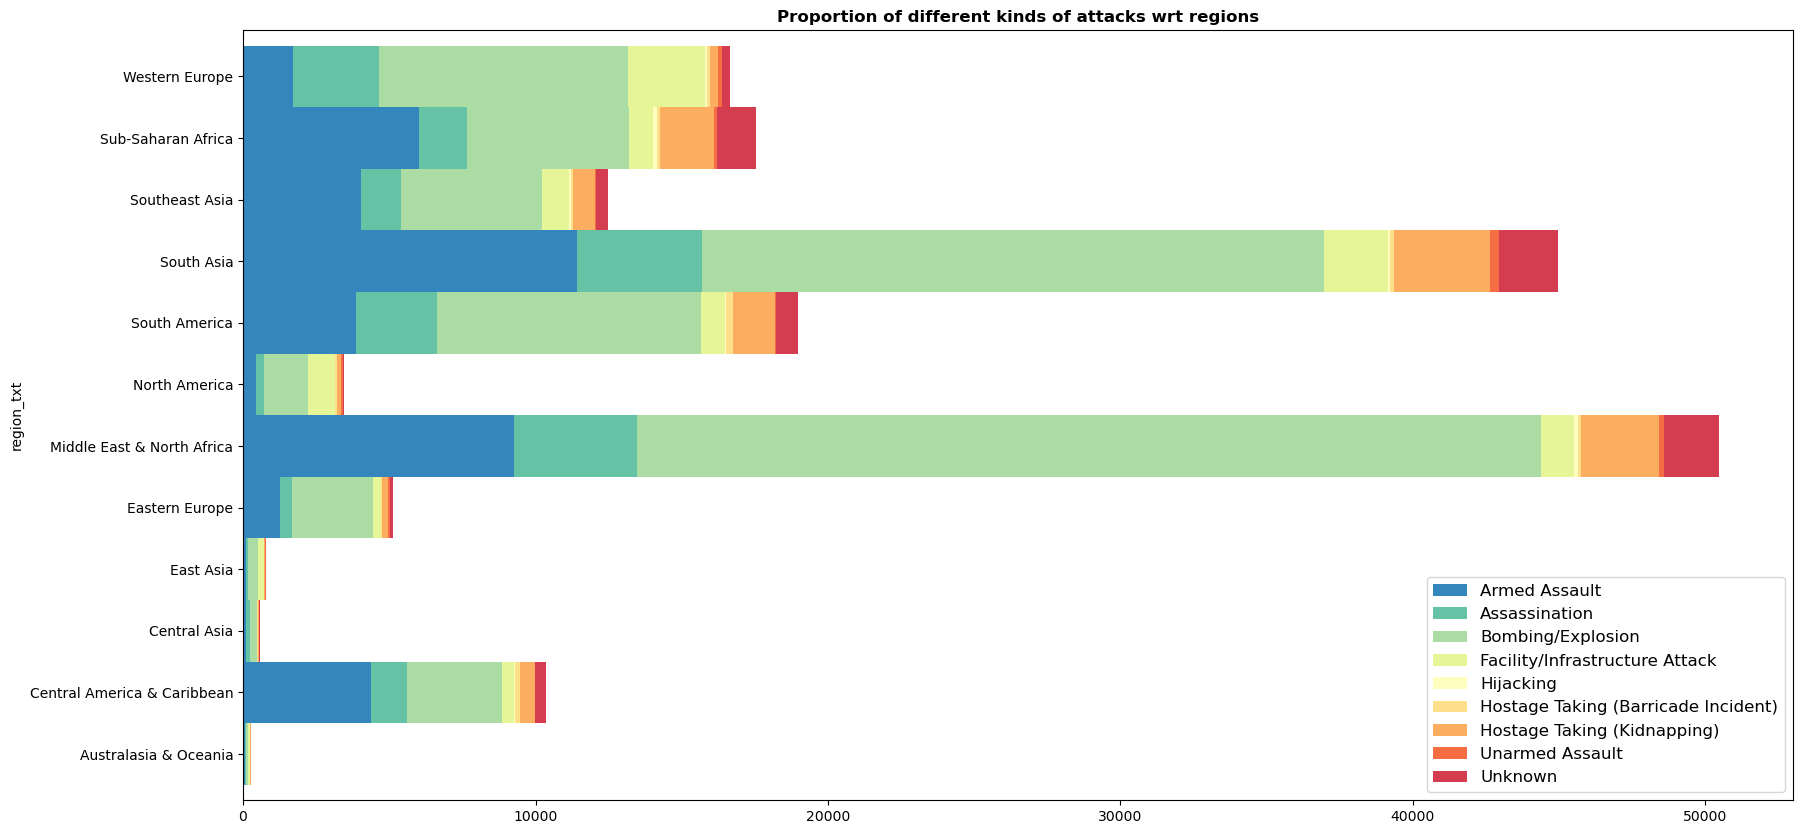

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1 , squeeze = False , figsize =(20,10))
total = float(len(gtcopy))
region_attacktype=pd.crosstab(gtcopy.region_txt, gtcopy.attacktype1_txt).plot(stacked=True,width=1,color=sns.color_palette('Spectral_r',9),kind = 'barh' , ax = ax[0][0])
plt.title('Proportion of different kinds of attacks wrt regions', weight = 'bold')
plt.legend(fontsize = 12)


/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


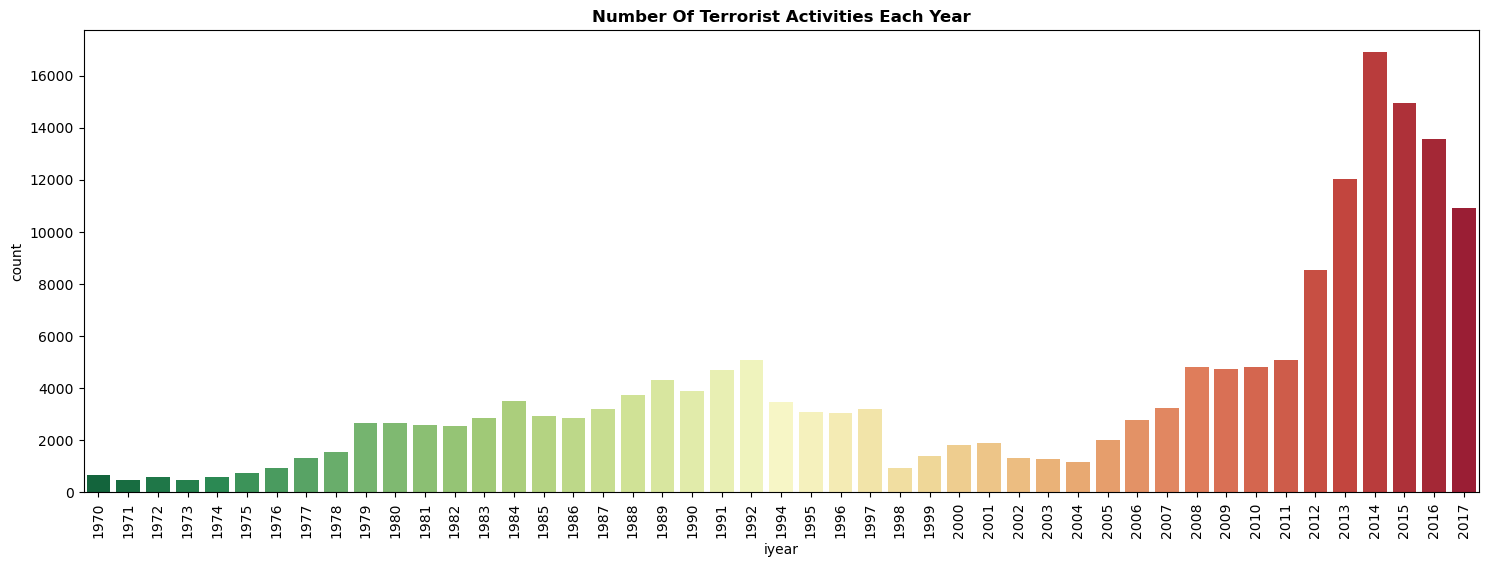

In [26]:
fig=plt.gcf()
fig.set_size_inches(18,6)
sns.countplot('iyear',data=gt,palette='RdYlGn_r')
plt.xticks(rotation=90)
plt.title('Number Of Terrorist Activities Each Year', weight='bold')
plt.show()


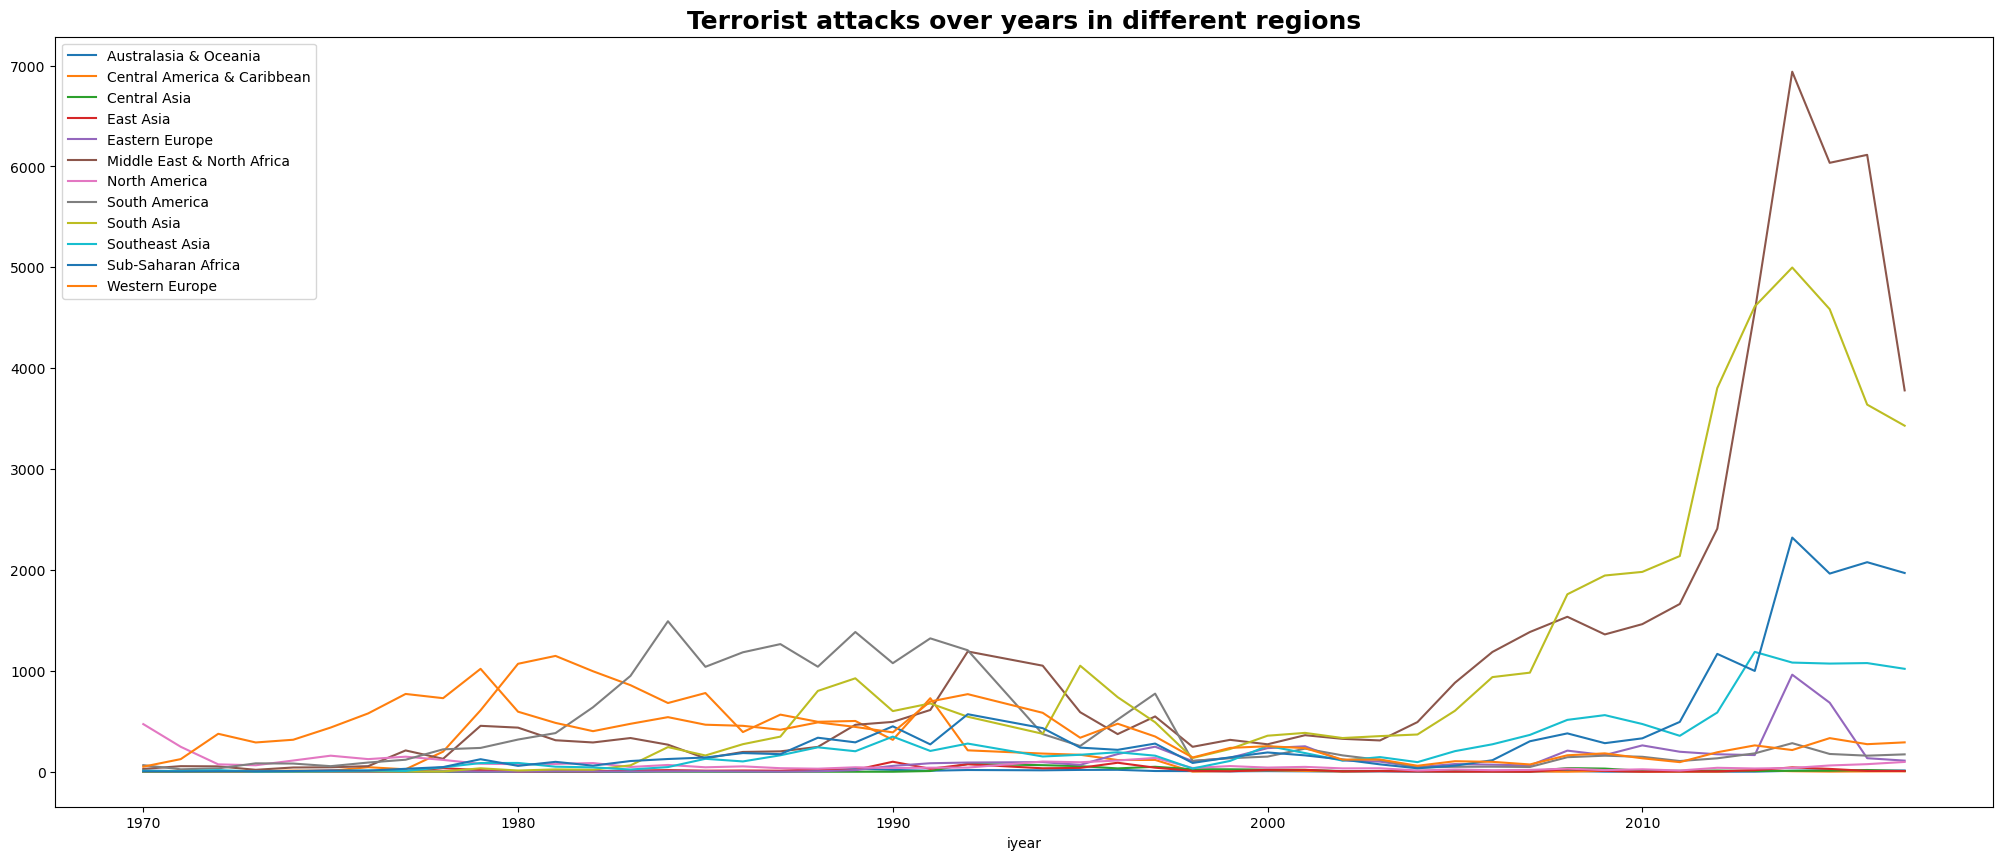

In [27]:
terror_region  = pd.crosstab(gtcopy.iyear , gtcopy.region_txt )
terror_region.plot()

fig=plt.gcf()
fig.set_size_inches(25,10)
plt.legend(loc='upper left')
plt.title("Terrorist attacks over years in different regions", weight = 'bold' ,fontsize = 18 ,loc = 'center')
plt.show()

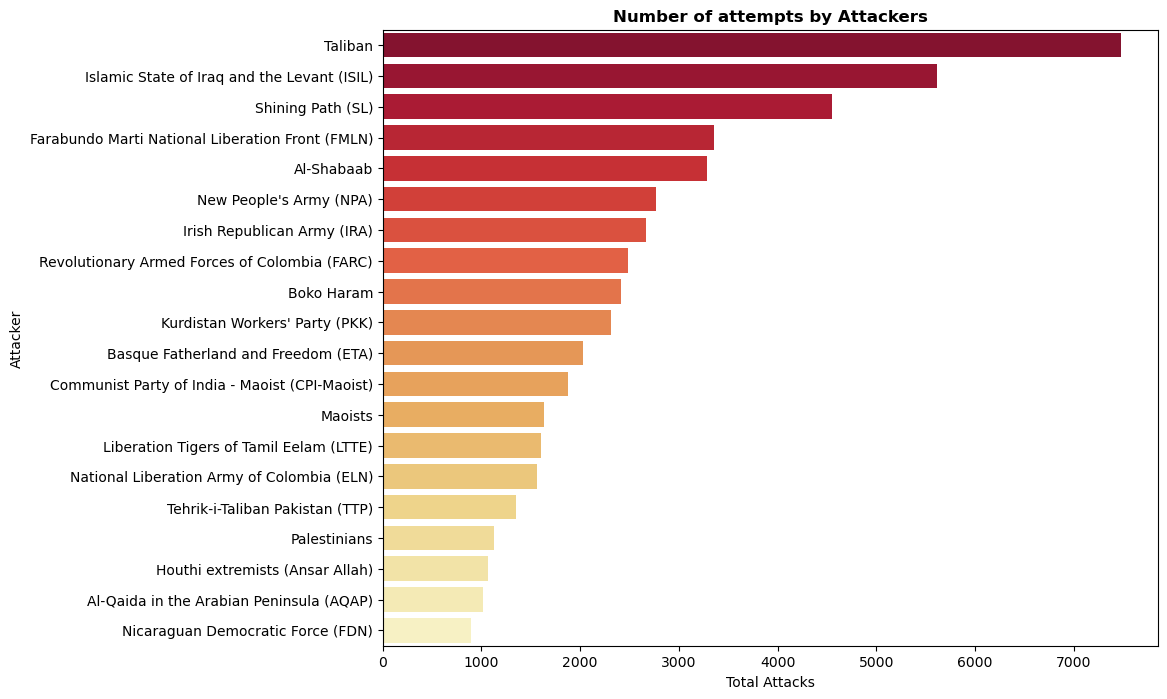

In [28]:
attacks_count = gt.gname.value_counts().to_frame().drop('Unknown').reset_index()[:20]
attacks_count.columns = ['Attacker', 'Total Attacks']
plt.subplots(figsize=(10,8))
sns.barplot(y=attacks_count['Attacker'], x=attacks_count['Total Attacks'], palette='YlOrRd_r')
plt.title('Number of attempts by Attackers', weight = 'bold')
plt.show()

In [29]:
gt = gt[["iyear", "imonth", "iday", "extended","country_txt","vicinity","multiple","success","suicide","attacktype1_txt","targtype1_txt","target1",
         "crit1", "crit2","crit3","doubtterr","gname" ,"guncertain1","weaptype1_txt","nkill","nwound","property","ishostkid"]]

In [30]:
gt = gt[(gt.crit1 == 1) & (gt.crit2 == 1) & (gt.crit3 == 1) & (gt.doubtterr == 0)]

In [31]:
gt=gt.rename(columns={'iyear':'year','imonth':'month','iday':'day','country_txt':'country','attacktype1_txt':'attack_type','targtype1_txt':'target_type',
                      'weaptype1_txt':'weapon_type','nkill':'killed','nwound':'wounded','gname':'attacker'})

In [32]:
gt['casualities'] = (gt['killed'] + gt['wounded'])  #add column for number of casualities = killed + wounded
gt['nclass'] = (gt.casualities.apply(lambda x: 0 if x == 0 else 1))  #create binary interpretation for casualities

In [33]:
gt = gt[["year", "month", "day", "extended","country","vicinity","multiple","success","suicide","attack_type","target_type","target1",
         "attacker" ,"guncertain1","weapon_type","killed","wounded","casualities","nclass","property","ishostkid"]]

In [34]:
gt.dropna(thresh=3, inplace=True)

gt['target_type']=gt['target_type'].fillna('Unknown')
gt['weapon_type']=gt['weapon_type'].fillna('Unknown')
gt['attacker']=gt['attacker'].fillna('Unknown')
gt.target1 = gt.target1.fillna('unknown').replace('unk','unknown')
gt.killed = np.round(gt.killed.fillna(gt.killed.median())).astype(int) 
gt.wounded = np.round(gt.wounded.fillna(gt.wounded.median())).astype(int)
gt.casualities = np.round(gt.casualities.fillna(gt.casualities.median())).astype(int)
gt.guncertain1.fillna(0, inplace = True)
gt.vicinity.replace(-9, 0, inplace = True)
gt.multiple.fillna(0, inplace = True)
gt.property.replace(-9, 0, inplace = True)
gt.ishostkid.fillna(0, inplace = True)

In [35]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
gt['country'] = lb.fit_transform(gt['country'])
gt['attack_type'] = lb.fit_transform(gt['attack_type'])
gt['target_type'] = lb.fit_transform(gt['target_type'])
gt['weapon_type'] = lb.fit_transform(gt['weapon_type'])
gt['target1'] = lb.fit_transform(gt['target1'])
gt['attacker'] = lb.fit_transform(gt['attacker'])

In [36]:
gt10 = gt[(gt.country == 83) | (gt.country== 132) | (gt.country==0) | (gt.country ==79) | (gt.country ==34) | 
          (gt.country ==137) | (gt.country ==138) | (gt.country == 186) | (gt.country == 129) | (gt.country == 177) ]

In [37]:
y = gt10.success

In [38]:
X= gt10[["year", "month", "day", "extended","country","vicinity","multiple","suicide","attack_type","target_type",
         "target1","attacker" ,"guncertain1","weapon_type","killed","wounded","property","ishostkid", "casualities", "nclass"]]

#Splitting Dataset

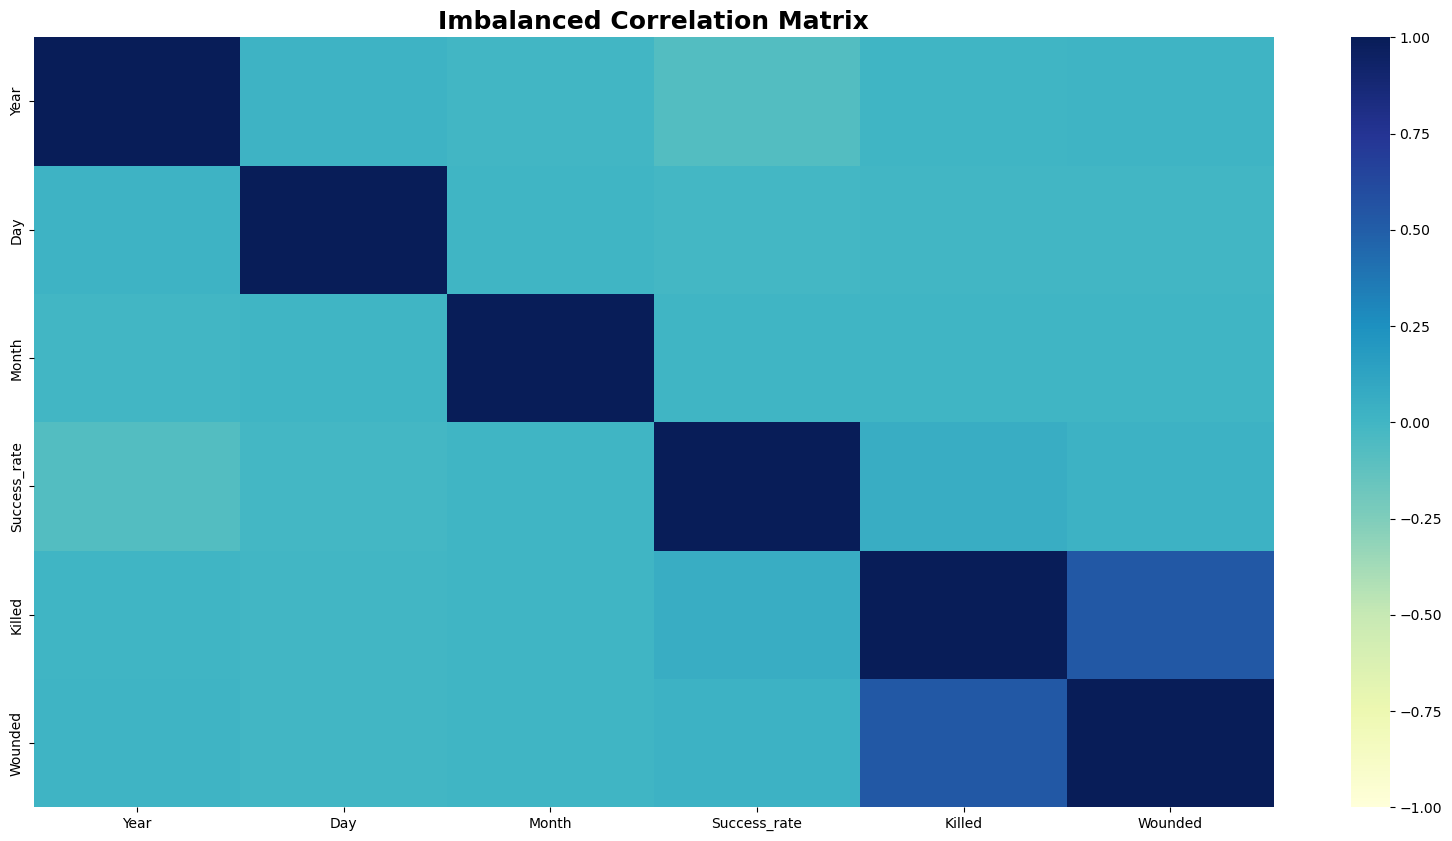

In [39]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         
# Imbalanced DataFrame Correlation
gtcopy6=gtcopy5.select_dtypes(np.number)
corr = gtcopy6.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax,vmax=1,vmin=-1)
ax.set_title("Imbalanced Correlation Matrix", fontsize=18, weight = 'bold')
plt.show()

In [40]:
vif_data = pd.DataFrame()
vif_data["feature"] = gtcopy6.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(gtcopy6.values, i) for i in range(len(gtcopy6.columns))]
print(vif_data)

        feature        VIF
0          Year  15.280327
1           Day   4.105939
2         Month   4.659472
3  Success_rate   8.490361
4        Killed   1.469633
5       Wounded   1.410575


In [41]:
gtcopy5.drop(columns="Year", inplace=True)

In [42]:
gtcopy7=gtcopy5.select_dtypes("object")
gtcopy7

,Country,City,Attack_type,Target,Weapon_type,Attacker
0,Dominican Republic,Santo Domingo,Assassination,Private Citizens & Property,Unknown,MANO-D
1,Mexico,Mexico city,Hostage Taking (Kidnapping),Government (Diplomatic),Unknown,23rd of September Communist League
2,Philippines,Unknown,Assassination,Journalists & Media,Unknown,Unknown
5,United States,Cairo,Armed Assault,Police,Firearms,Black Nationalists
6,Uruguay,Montevideo,Assassination,Police,Firearms,Tupamaros (Uruguay)
...,...,...,...,...,...,...
181686,Somalia,Ceelka Geelow,Armed Assault,Military,Firearms,Al-Shabaab
181687,Syria,Jableh,Bombing/Explosion,Military,Explosives,Muslim extremists
181688,Philippines,Kubentog,Facility/Infrastructure Attack,Private Citizens & Property,Incendiary,Bangsamoro Islamic Freedom Movement (BIFM)
181689,India,Imphal,Bombing/Explosion,Government (General),Explosives,Unknown


In [43]:
for i in gtcopy7.columns:
    top_10 = gtcopy7[i].value_counts().head(10).index
    for j in gtcopy7.index:
        if( gtcopy7.loc[j,i] not in top_10):
            gtcopy7.loc[j,i] = 'others'

In [44]:
gtcopy7_en = pd.get_dummies(gtcopy7, drop_first=True)
gtcopy7_en

,Country_Colombia,Country_El Salvador,Country_India,Country_Iraq,Country_Pakistan,Country_Peru,Country_Philippines,Country_Thailand,Country_Turkey,Country_others,...,Attacker_Basque Fatherland and Freedom (ETA),Attacker_Farabundo Marti National Liberation Front (FMLN),Attacker_Islamic State of Iraq and the Levant (ISIL),Attacker_Kurdistan Workers' Party (PKK),Attacker_New People's Army (NPA),Attacker_Revolutionary Armed Forces of Colombia (FARC),Attacker_Shining Path (SL),Attacker_Taliban,Attacker_Unknown,Attacker_others
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181686,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
181687,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
181688,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
181689,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [45]:
gtcopy6

,Year,Day,Month,Success_rate,Killed,Wounded
0,1970,2,7,1,1.0,0.0
1,1970,0,0,1,0.0,0.0
2,1970,0,1,1,1.0,0.0
5,1970,1,1,1,0.0,0.0
6,1970,2,1,0,0.0,0.0
...,...,...,...,...,...,...
181686,2017,31,12,1,1.0,2.0
181687,2017,31,12,1,2.0,7.0
181688,2017,31,12,1,0.0,0.0
181689,2017,31,12,0,0.0,0.0


In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
gt_num_sc = pd.DataFrame(sc.fit_transform(gtcopy6.drop(columns ="Success_rate")), 
                         columns=gtcopy6.drop(columns ="Success_rate").columns, 
                         index=gtcopy6.drop(columns ="Success_rate").index)

In [47]:
gtcopy_final = pd.concat([gt_num_sc,gtcopy7_en,gtcopy6['Success_rate']], axis=1)

In [48]:
gtcopy_final

,Year,Day,Month,Killed,Wounded,Country_Colombia,Country_El Salvador,Country_India,Country_Iraq,Country_Pakistan,...,Attacker_Farabundo Marti National Liberation Front (FMLN),Attacker_Islamic State of Iraq and the Levant (ISIL),Attacker_Kurdistan Workers' Party (PKK),Attacker_New People's Army (NPA),Attacker_Revolutionary Armed Forces of Colombia (FARC),Attacker_Shining Path (SL),Attacker_Taliban,Attacker_Unknown,Attacker_others,Success_rate
0,-2.593965,-1.534766,0.152891,-0.115406,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,-2.593965,-1.761858,-1.913203,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,-2.593965,-1.761858,-1.618047,-0.115406,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5,-2.593965,-1.648312,-1.618047,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,-2.593965,-1.534766,-1.618047,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181686,1.081054,1.758079,1.628672,-0.115406,-0.032423,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
181687,1.081054,1.758079,1.628672,-0.013585,0.106279,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
181688,1.081054,1.758079,1.628672,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
181689,1.081054,1.758079,1.628672,-0.217226,-0.087903,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [49]:
!pip install imblearn

In [50]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()

X,y = sm.fit_resample(gtcopy_final.drop(columns='Success_rate'),
                      gtcopy_final['Success_rate'])


/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Success_rate', ylabel='count'>

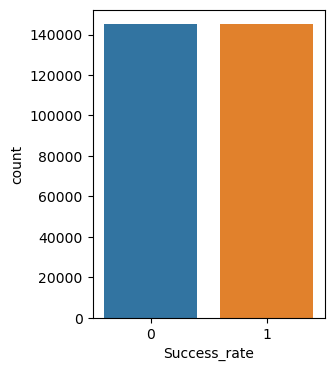

In [51]:
plt.figure(figsize=(3,4))
sns.countplot(y)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (232020, 63)
y_train shape:  (232020,)
X_test shape:  (58006, 63)
y_test shape:  (58006,)


#Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression 

def doLogisticRegression(X, y, normalize=False):
  # If normalize option is enabled,
  if normalize:
    # For each feature (indexed by j as usual)
    for j in X.columns:
      # Subtract its column mean and update the value.
      X[j] -= X[j].mean()

      # Divide by its standard deviation and update the value.
      X[j] /= X[j].std()

  # Instanciate an object from Logistic Regression class.
  lr = LogisticRegression()

  # Perform training and prediction.
  lr.fit(X, y)
  y_pred_lr = lr.predict(X)
      
  # Return training accuracy and confusion matrix.
  return accuracy_score(y, y_pred_lr), confusion_matrix(y, y_pred_lr), lr

TrainAcc, TrainConf, LR = doLogisticRegression(X_train, y_train, normalize=True)
print(TrainAcc)
print(TrainConf)

0.7455564175502112
[[86044 30040]
 [28996 86940]]


In [54]:
y_test_pred = LR.predict(X_test)
TestAcc, TestConf = accuracy_score(y_test, y_test_pred), confusion_matrix(y_test, y_test_pred)
print(TestAcc)
print(TestConf)

0.5017756783780988
[[   29 28900]
 [    0 29077]]


In [55]:
 roc_auc_score(y_test, y_test_pred)

0.5005012271423139

/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


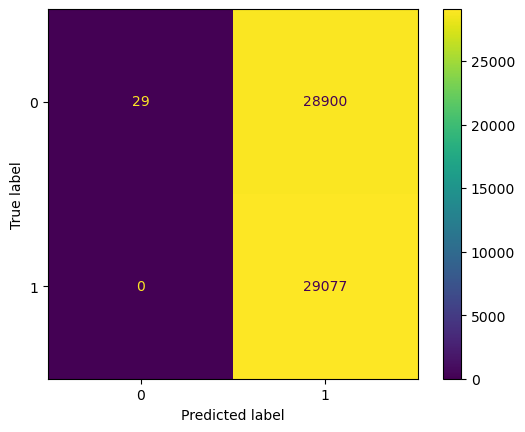

In [56]:
plot_confusion_matrix(LR,X_test, y_test)

In [57]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     28929
           1       0.50      1.00      0.67     29077

    accuracy                           0.50     58006
   macro avg       0.75      0.50      0.34     58006
weighted avg       0.75      0.50      0.34     58006



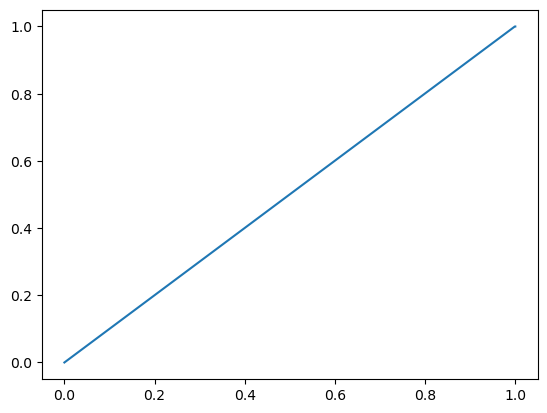

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr,tpr)

In [59]:
param_grid = {"C":[0.5,1,10,100],
              "penalty":["l1","l2","elasticnet"],
              "solver":["newton-cg", "lbfgs"],
              "max_iter":[100,500,1000]}
LR = LogisticRegression()
#using gridsearchcv with cross validation=5
LR_grid = GridSearchCV(LR, param_grid, cv = 5, scoring = 'roc_auc', refit = True, verbose = 3)
# Fitting the model
LR_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.5, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.5, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.5, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.5, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.5, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.5, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.5

[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.830 total time=   1.5s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.829 total time=   1.6s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.829 total time=   1.7s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.830 total time=   2.0s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.831 total time=   1.6s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.830 total time=   0.9s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.829 total time=   0.8s


/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.829 total time=   1.0s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.830 total time=   0.9s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.831 total time=   0.8s
[CV 1/5] END C=1, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=100, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalt

[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.830 total time=   0.9s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.829 total time=   0.8s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.829 total time=   1.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.830 total time=   1.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.831 total time=   0.8s
[CV 1/5] END C=10, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty

[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.829 total time=   1.6s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.830 total time=   2.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.831 total time=   1.6s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.830 total time=   1.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.829 total time=   0.8s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.829 total time=   1.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.830 total time=   1.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.831 total time=   0.8s
[CV 1/5] END C=100, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=elasti

/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1, 10, 100], 'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs']},
             scoring='roc_auc', verbose=3)

In [60]:
LR_grid.best_params_

{'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [61]:
LRTuned=LR_grid.best_estimator_.predict(X_test)

In [62]:
roc_auc_score(y_test, LRTuned)

0.5005012271423139

#KNN

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train,y_train)

In [65]:
pred = knn_model.predict(X_test)

/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [66]:

roc_auc_score(y_test,pred)

0.5819651874685616

In [67]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.60      0.50      0.54     28929
           1       0.57      0.67      0.62     29077

    accuracy                           0.58     58006
   macro avg       0.58      0.58      0.58     58006
weighted avg       0.58      0.58      0.58     58006



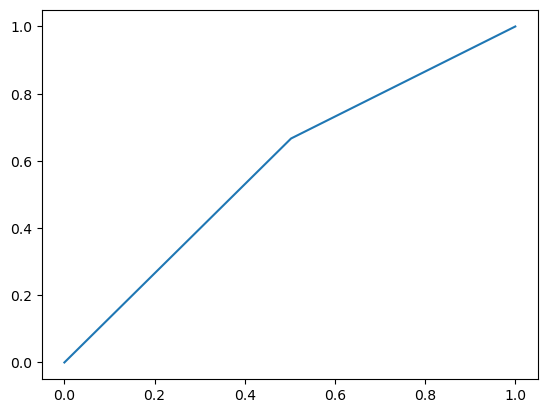

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.plot(fpr, tpr)


In [69]:
param_grid = {'weights':['uniform', 'distance'],

              'n_neighbors':[3,5]}

knn = KNeighborsClassifier()
#using gridsearchcv with cross validation=5
knn_grid = GridSearchCV(knn, param_grid, cv = 5, scoring = 'roc_auc', refit = True, verbose = 3)
# Fitting the model
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.925 total time= 1.7min
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.925 total time= 1.8min
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.926 total time= 1.8min
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.926 total time= 1.8min
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.927 total time= 1.8min
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.931 total time= 1.8min
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.930 total time= 1.8min
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.932 total time= 1.8min
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.931 total time= 1.8min
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.932 total time= 1.8min
[CV 1/5] END ....n_neighbors=5, weights=uniform;, score=0.928 total time= 2.3min
[CV 2/5] END ....n_neighbors=5, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=3)

In [70]:
knn_grid.best_params_

{'n_neighbors': 5, 'weights': 'distance'}

In [71]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_best = knn.fit(X_train, y_train)
ypred_knn = knn_best.predict(X_test)

In [72]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.50      0.54     28929
           1       0.57      0.67      0.62     29077

    accuracy                           0.58     58006
   macro avg       0.58      0.58      0.58     58006
weighted avg       0.58      0.58      0.58     58006



In [73]:
roc_auc_score(y_test, pred)

0.5819651874685616

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, ypred_knn)

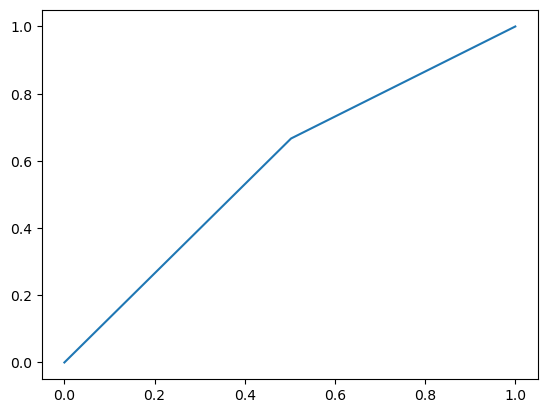

In [75]:
plt.plot(fpr, tpr)


#Random Forest

In [76]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, y_train)

In [77]:
pred = rf_model.predict(X_test)

In [78]:
accuracy_score(y_test,pred)

0.6243147260628211

In [79]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.58      0.87      0.70     28929
           1       0.75      0.38      0.50     29077

    accuracy                           0.62     58006
   macro avg       0.67      0.62      0.60     58006
weighted avg       0.67      0.62      0.60     58006



/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


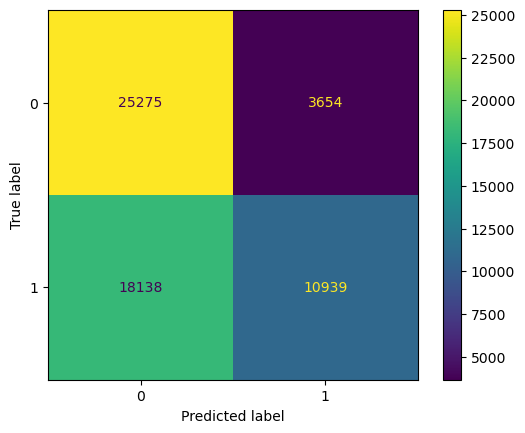

In [80]:
plot_confusion_matrix(rf_model,X_test, y_test)

In [81]:
roc_auc_score(y_test,pred)       

0.6249493797933119

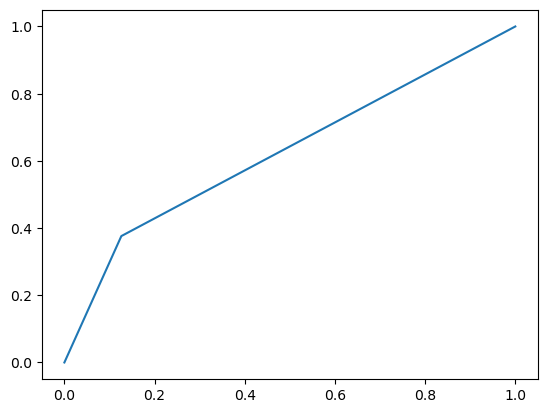

In [82]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
plt.plot(fpr,tpr)

In [83]:
param_grid = {'criterion':["gini", "entropy"],
              'n_estimators':[100,200]}

rf = RandomForestClassifier()
#using gridsearchcv with cross validation=5
rf_grid = GridSearchCV(rf, param_grid, cv = 5, scoring = 'roc_auc', refit = True, verbose = 3)
# Fitting the model
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..criterion=gini, n_estimators=100;, score=0.988 total time=  15.8s
[CV 2/5] END ..criterion=gini, n_estimators=100;, score=0.988 total time=  15.9s
[CV 3/5] END ..criterion=gini, n_estimators=100;, score=0.988 total time=  16.0s
[CV 4/5] END ..criterion=gini, n_estimators=100;, score=0.988 total time=  16.0s
[CV 5/5] END ..criterion=gini, n_estimators=100;, score=0.989 total time=  15.8s
[CV 1/5] END ..criterion=gini, n_estimators=200;, score=0.988 total time=  32.0s
[CV 2/5] END ..criterion=gini, n_estimators=200;, score=0.989 total time=  31.9s
[CV 3/5] END ..criterion=gini, n_estimators=200;, score=0.989 total time=  32.3s
[CV 4/5] END ..criterion=gini, n_estimators=200;, score=0.989 total time=  32.0s
[CV 5/5] END ..criterion=gini, n_estimators=200;, score=0.989 total time=  32.0s
[CV 1/5] END criterion=entropy, n_estimators=100;, score=0.988 total time=  17.4s
[CV 2/5] END criterion=entropy, n_estimators=100

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=3)

In [84]:
rf_grid.best_params_

{'criterion': 'entropy', 'n_estimators': 200}

In [85]:
rf = RandomForestClassifier(criterion='entropy', n_estimators=200)
rf_best = rf.fit(X_train, y_train)
ypred_rf = rf_best.predict(X_test)

In [86]:
print(classification_report(y_test, ypred_rf))

              precision    recall  f1-score   support

           0       0.58      0.89      0.71     28929
           1       0.77      0.37      0.50     29077

    accuracy                           0.63     58006
   macro avg       0.68      0.63      0.60     58006
weighted avg       0.68      0.63      0.60     58006



In [87]:
roc_auc_score(y_test,ypred_rf)

0.6297773837433835

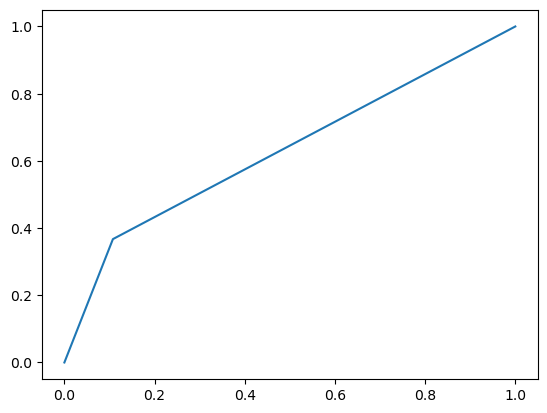

In [88]:
fpr, tpr, thresholds = roc_curve(y_test, ypred_rf)
plt.plot(fpr,tpr)

In [89]:
roc_lr = roc_auc_score(y_test, y_test_pred)
roc_knn = roc_auc_score(y_test, ypred_knn)
roc_rf = roc_auc_score(y_test, ypred_rf)
acc_lr= accuracy_score(y_test, y_test_pred)
acc_knn = accuracy_score(y_test, ypred_knn)
acc_rf= accuracy_score(y_test, ypred_rf)
f1_lr = f1_score(y_test, y_test_pred)
f1_knn= f1_score(y_test, ypred_knn)
f1_rf = f1_score(y_test, ypred_rf)

In [90]:
pd.DataFrame({"Models":["Logistic Regression","KNN","Random Forest"],"roc auc":[roc_lr,roc_knn,roc_rf],"accuracy":[acc_lr,acc_knn,acc_rf],"F1 Score":[f1_lr,f1_knn,f1_rf]})

,Models,roc auc,accuracy,F1 Score
0,Logistic Regression,0.500501,0.501776,0.668022
1,KNN,0.581965,0.582181,0.615314
2,Random Forest,0.629777,0.629107,0.498110


#Naive Bayes

Accuracy on Train set:   0.7055512455822774
Accuracy on Test set:   0.6911871185739407
Confusion matrix : 
 [[21469  7460]
 [10453 18624]]

Classification Report : 
               precision    recall  f1-score   support

     class 0       0.67      0.74      0.71     28929
     class 1       0.71      0.64      0.68     29077

    accuracy                           0.69     58006
   macro avg       0.69      0.69      0.69     58006
weighted avg       0.69      0.69      0.69     58006

Mean Squared error :  0.5557093497738358
naive bayes cross validation score: 0.6640645680416011


/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


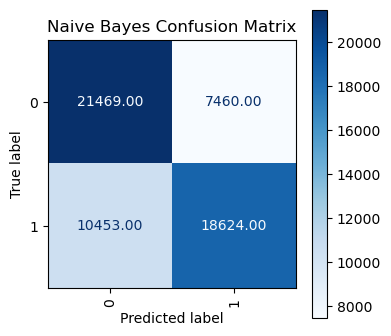

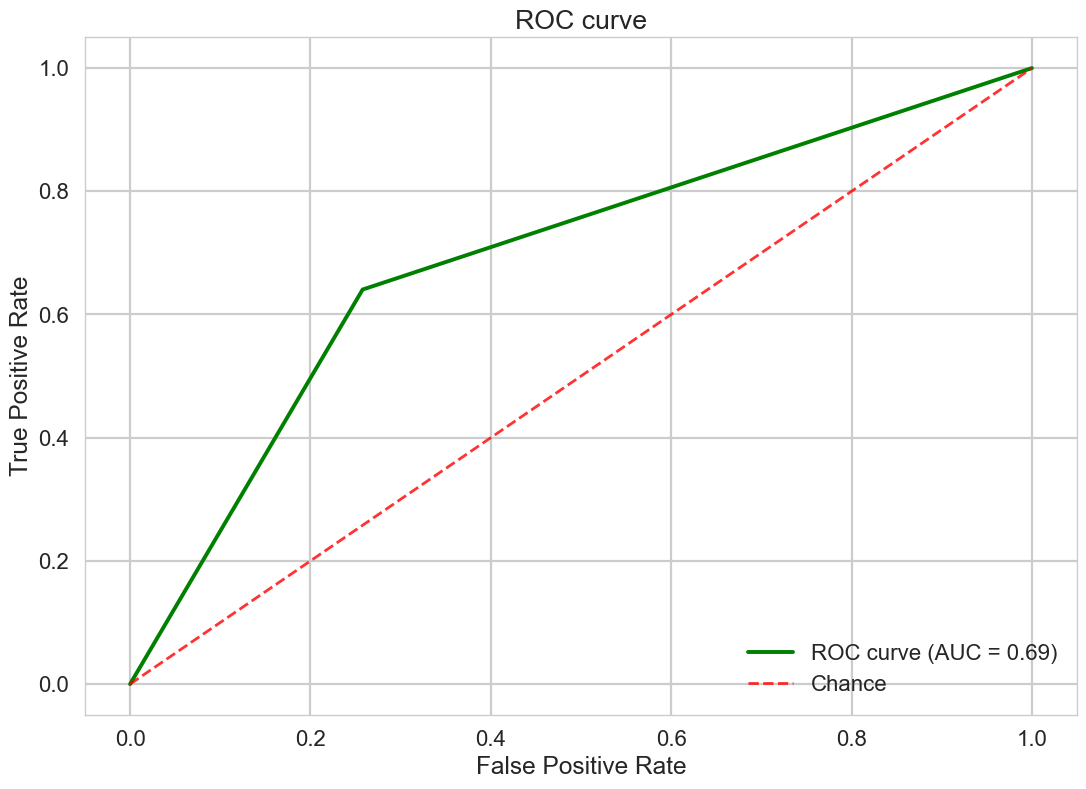

In [91]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
ypred = bnb.fit(X_train, y_train).predict(X_test)

print("Accuracy on Train set:  ", bnb.score(X_train,y_train))
print("Accuracy on Test set:  ",bnb.score(X_test,y_test))

print('Confusion matrix : \n',confusion_matrix(y_test,ypred))
print('\nClassification Report : \n',classification_report(y_test, ypred, target_names=['class 0', 'class 1']))
print('Mean Squared error : ',mean_squared_error(y_test, ypred, squared=False))

cvnb = cross_val_score(bnb, X_test, y_test, cv = 3, scoring = 'recall').mean()
print('naive bayes cross validation score:', cvnb)

fig, ax = plt.subplots(figsize = (4,4))

matrix = plot_confusion_matrix(bnb, X_test, y_test, ax=ax, xticks_rotation='vertical', 
                               cmap='Blues', values_format='.2f')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

plt.style.use(['seaborn-whitegrid','seaborn-poster'])
fpr, tpr, thresholds = roc_curve(y_test, ypred)
auc = roc_auc_score(y_test, ypred)
plt.plot(fpr, tpr,color='g', label = "ROC curve (AUC = "+str(round(auc,2))+')')
plt.plot([0,1],[0,1], linestyle = '--', lw=2, color ='r', label='Chance', alpha=.8)
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()

#SVM

In [92]:
from sklearn.svm import LinearSVC

In [93]:
svmmodel= LinearSVC()
svmmodel_model = svmmodel.fit(X_train, y_train)

/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [94]:
y_pred_svmmodel = svmmodel.predict(X_test)

In [95]:
roc_auc_score(y_test, y_pred_svmmodel)

0.5004148086695012

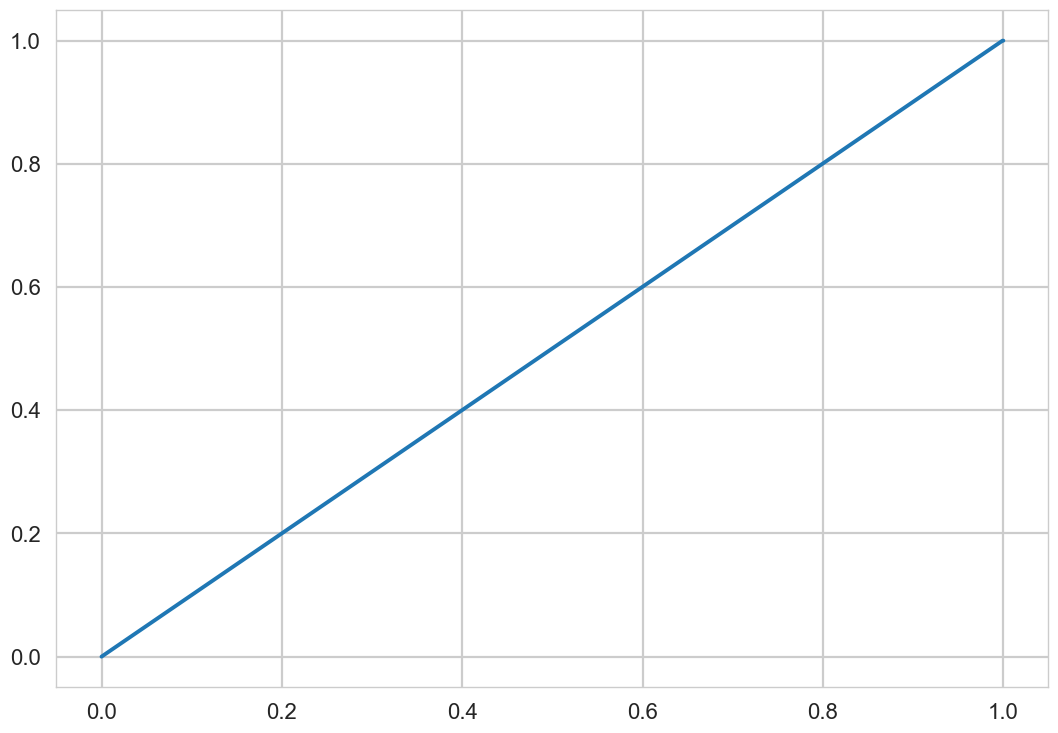

In [96]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svmmodel)
plt.plot(fpr,tpr)

In [97]:
param_grid = {"penalty" : ['l2','l1'], "C":[1,100,500]}
lsvc= LinearSVC(dual=False)
svcgrid= GridSearchCV(lsvc, param_grid, scoring= 'roc_auc', cv= 3, verbose = 3)
svcgrid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ...................C=1, penalty=l2;, score=0.824 total time=   2.7s
[CV 2/3] END ...................C=1, penalty=l2;, score=0.825 total time=   2.5s
[CV 3/3] END ...................C=1, penalty=l2;, score=0.825 total time=   2.5s
[CV 1/3] END ...................C=1, penalty=l1;, score=0.824 total time=  12.9s
[CV 2/3] END ...................C=1, penalty=l1;, score=0.825 total time=  15.2s
[CV 3/3] END ...................C=1, penalty=l1;, score=0.825 total time=  13.8s
[CV 1/3] END .................C=100, penalty=l2;, score=0.824 total time=   2.6s
[CV 2/3] END .................C=100, penalty=l2;, score=0.825 total time=   2.5s
[CV 3/3] END .................C=100, penalty=l2;, score=0.825 total time=   2.5s
[CV 1/3] END .................C=100, penalty=l1;, score=0.824 total time=  13.3s
[CV 2/3] END .................C=100, penalty=l1;, score=0.825 total time=  14.8s
[CV 3/3] END .................C=100, penalty=l1;,

GridSearchCV(cv=3, estimator=LinearSVC(dual=False),
             param_grid={'C': [1, 100, 500], 'penalty': ['l2', 'l1']},
             scoring='roc_auc', verbose=3)

In [98]:
best_svc = svcgrid.best_estimator_.fit(X_train,y_train)

In [99]:
ypred_best = best_svc.predict(X_test)

In [100]:
roc_auc_score(y_test, ypred_best)

0.5004148086695012

In [101]:
gtcopy_final

,Year,Day,Month,Killed,Wounded,Country_Colombia,Country_El Salvador,Country_India,Country_Iraq,Country_Pakistan,...,Attacker_Farabundo Marti National Liberation Front (FMLN),Attacker_Islamic State of Iraq and the Levant (ISIL),Attacker_Kurdistan Workers' Party (PKK),Attacker_New People's Army (NPA),Attacker_Revolutionary Armed Forces of Colombia (FARC),Attacker_Shining Path (SL),Attacker_Taliban,Attacker_Unknown,Attacker_others,Success_rate
0,-2.593965,-1.534766,0.152891,-0.115406,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,-2.593965,-1.761858,-1.913203,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,-2.593965,-1.761858,-1.618047,-0.115406,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5,-2.593965,-1.648312,-1.618047,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
6,-2.593965,-1.534766,-1.618047,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181686,1.081054,1.758079,1.628672,-0.115406,-0.032423,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
181687,1.081054,1.758079,1.628672,-0.013585,0.106279,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
181688,1.081054,1.758079,1.628672,-0.217226,-0.087903,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
181689,1.081054,1.758079,1.628672,-0.217226,-0.087903,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


#kMeans

In [102]:
from sklearn.cluster import KMeans

In [103]:
km = KMeans(n_clusters=3)
clust_model = km.fit(gtcopy_final)
gtcopy_final['label'] = clust_model.labels_

/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


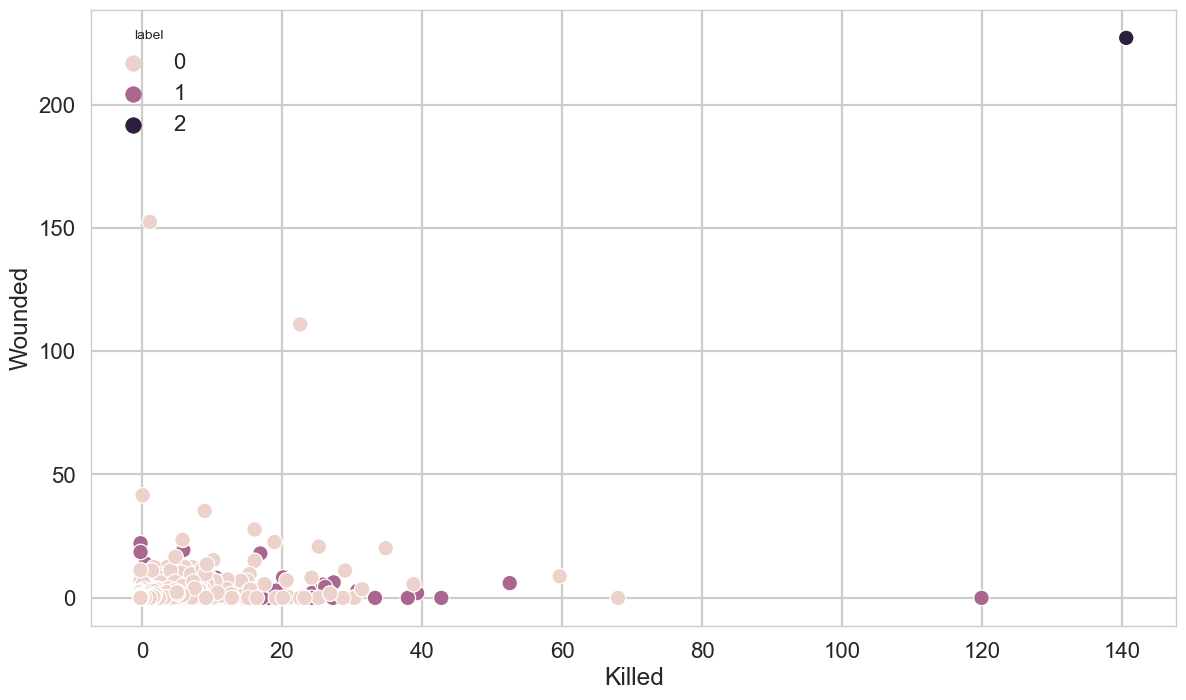

In [104]:
plt.figure(figsize=(14,8))
sns.scatterplot(gtcopy_final['Killed'], gtcopy_final['Wounded'], hue=gtcopy_final['label'])
plt.show()

In [105]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
new_comp = pca.fit_transform(gtcopy_final)

In [106]:
pca_df = pd.DataFrame(new_comp, columns={'comp1','comp2'})
pca_df

,comp1,comp2
0,-0.239219,2.924139
1,-0.344670,2.923973
2,-0.311794,2.570424
3,-0.332096,2.935942
4,-0.355542,2.960647
...,...,...
164379,-0.028651,-0.893664
164380,0.153954,-1.067404
164381,-0.134698,-0.989932
164382,-0.188875,-1.502810


/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


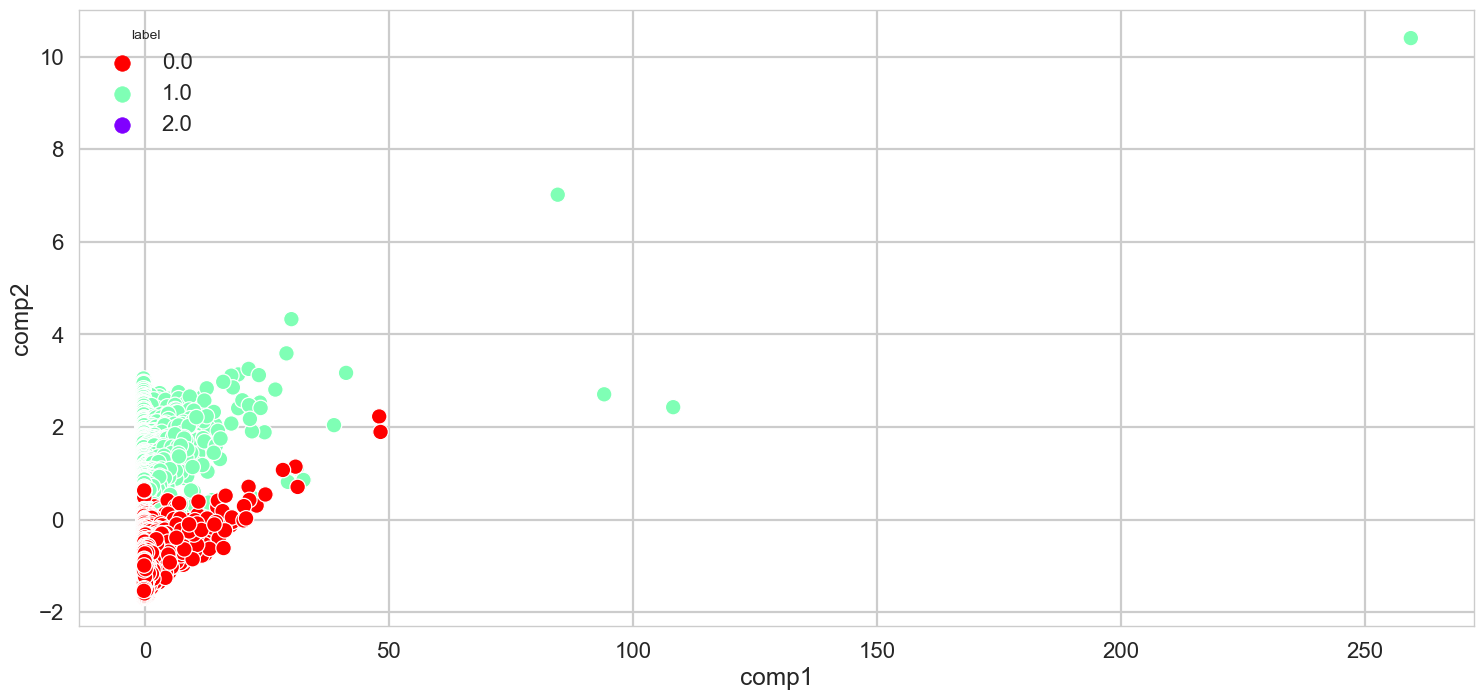

In [107]:
plt.figure(figsize=(18,8))
sns.scatterplot(pca_df['comp1'], pca_df['comp2'], hue=gtcopy_final['label'], palette='rainbow_r')
plt.show()

In [108]:
from sklearn import metrics

In [109]:
for n in range(2,6): 
    km = KMeans(n_clusters=n)
    clust_model = km.fit(gtcopy_final)
    gtcopy_final['label'] = clust_model.labels_
    print("Silhouette Score for k=",n," :", metrics.silhouette_score(gtcopy_final, clust_model.labels_))

Silhouette Score for k= 2  : 0.16440709129862457
Silhouette Score for k= 3  : 0.1649507948003413
Silhouette Score for k= 4  : 0.17575004118867887
Silhouette Score for k= 5  : 0.1796514399996095


/Users/vishalbrahmananda/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


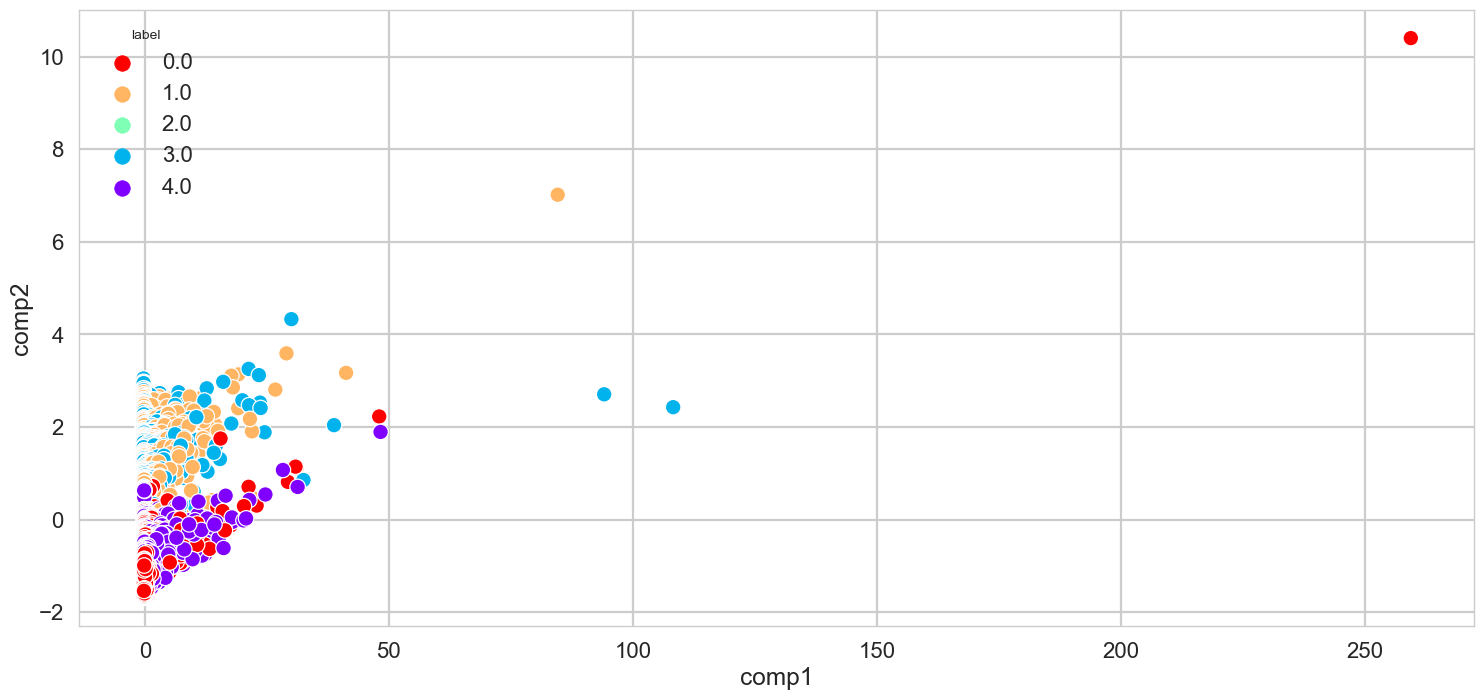

In [110]:
plt.figure(figsize=(18,8))
sns.scatterplot(pca_df['comp1'], pca_df['comp2'], hue=gtcopy_final['label'], palette='rainbow_r')
plt.show()

In [ ]:
## The best number of clusters is 5. The above 